# Variational Autoencoders (Model definition & training)

This notebook contains the implementation of two variational autoencoders, one using [autograd](https://github.com/HIPS/autograd) and one using [JAX](https://github.com/google/jax), the successor to autograd that supports GPU execution. The VAEs are largely identical save for the changes necessary to support JAX. The implementation was based on lecture notes 20.

*   <a href="#section_vae">Autograd VAE</a>
*   <a href="#section_gpu_vae">JAX VAE</a>

The notebook also contains 7 concrete instantiations of those VAE models:
- [VAE 1](#vae1): 2D Gaussian reconstruction, for validation purposes only.
- [VAE 2](#vae2): Mixture of Gaussians reconstruction, for validation purposes only.
- [VAE 3](#vae3): VAE trained on 3 variable fake loan data.
- [VAE 4](#vae4): VAE trained on full fake loan data.
- [VAE 5](#vae5): VAE trained on COMPAS data
- [VAE 6](#vae6): VAE trained on full fake loan data generated using a VAE.
- [VAE 7](#vae7): VAE trained on COMPAS data generated using a VAE.

**Note**: the sections above only work in Jupyter, on Colab use the built-in table-of-contents instead.



In [ ]:
import time
import sys
import datetime
import os

from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
import autograd.scipy.stats.norm as norm

import numpy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
from jax import jit
from jax import random as jrandom
from jax import numpy as jnp
from jax import scipy as jsp
from jax import grad as jgrad
from jax.experimental.optimizers import adam as jadam
from jax.scipy.stats import multivariate_normal as jmultivariate_normal
from jax.scipy.stats import norm as jnorm

In [ ]:
# Use for dark mode (don't run if not using dark mode) 
plt.style.use('dark_background')

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab. Mounting google drive...')
  from google.colab import drive
  drive.mount('/content/gdrive')
  base_path = '/content/gdrive/Shareddrives/AM207 - CLUE Final Project/_ForSubmission'
else:
  print('Not running on CoLab.')
  base_path = os.path.abspath("../")

Running on CoLab. Mounting google drive...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_path = f"{base_path}/data"
parameter_path = f"{base_path}/model_parameters"

print(f"Data path: {data_path}.")
print(f"Parameter path: {parameter_path}.")

Data path: /content/gdrive/Shareddrives/AM207 - CLUE Final Project/_ForSubmission/data.
Parameter path: /content/gdrive/Shareddrives/AM207 - CLUE Final Project/_ForSubmission/model_parameters.


# Helper functions

In [ ]:
import pickle
import json 

ENCODING_KEY = "encoder_weigths"
DECODING_KEY = "decoder_weigths"

def save_architecture(encoder, decoder, D, filename):
  """ Writes a JSON file with the NN architecture """
  with open(filename, "w") as f:
     architecture_dict = {
         "encoder": [layer.units for layer in encoder],
         "decoder": [layer.units for layer in decoder],
         "D": D
     }     
     json.dump(architecture_dict, f)


def pickle_vae_weights(vae, filename):
  """ Pickles the weights of a VAE """
  future_pickles = {
      ENCODING_KEY: vae.encoder_weights,
      DECODING_KEY: vae.decoder_weights   
  }
  with open(filename, "wb") as f:
    pickle.dump(future_pickles, f)

def unpickle_vae_weights(filename):
  """ As if by magic, reverses the pickling process to produce VAE weights """
  with open(filename, "rb") as f:
    weight_dict = pickle.load(f)
    return (weight_dict[ENCODING_KEY], weight_dict[DECODING_KEY])

  

# Activation functions

In [ ]:
# Regular numpy
relu = lambda x: np.maximum(np.zeros(x.shape), x)
identity = lambda x: x
sigmoid = lambda x: 1 / (1 + np.exp(-x))

# JAX
jrelu = lambda x: jnp.maximum(jnp.zeros(x.shape), x)
jsigmoid = lambda x: 1 / (1 + jnp.exp(-x))

# VAE Definition

In [ ]:
class Dense:
  """ Dense is a simple class to allow for syntactically pleasing 
  network architecture definition """
  def __init__(self, units, activation):
    self.units = units
    self.activation = activation

<a id="section_vae"> 
## Vanilla VAE (autograd, unaccelerated)


In [ ]:
class VAE():
  """ This class implements a vanilla VAE,
  using the likelihood - kl formulation """
  def __init__(self, 
               encoder, 
               decoder, 
               encoder_weights=None, 
               decoder_weights=None,
               random=None):
    """ Constructor for VAE
    param encoder: Architecture of encoder, a list of Dense objects.
    param decoder: Architecture of encoder, a list of Dense objects.
    param encoder_weights: Encoder weights to initialize VAE with
    param decoder_weights: Decoder weights to initialize VAE with
    param random: Numpy randomstate to use (if None, it will be created)
    """
    self.encoder = encoder
    self.decoder = decoder

    self.D_encoder = self.compute_weights_size(encoder)
    self.D_decoder = self.compute_weights_size(decoder)

    if random is not None:
      self.random = random
    else:
      self.random = np.random.RandomState(0)

    # Initialize weights of the neural nets
    self.encoder_weights = encoder_weights
    self.decoder_weights = decoder_weights
    if self.encoder_weights is None:
      self.encoder_weights = self.init_weights(self.D_encoder)
    if self.decoder_weights is None:
      self.decoder_weights = self.init_weights(self.D_decoder)


  def compute_weights_size(self, network):
    """ Computes the size/shape of the given network """
    num_weights = 0
    for previous_layer, current_layer in zip(network, network[1:]):      
      num_weights += previous_layer.units * current_layer.units + current_layer.units      
    return num_weights


  def init_weights(self, D):
    """ Initialize the weights of the encoder & decoder """
    ### TODO: Better weight init?
    # return np.zeros(shape=(1,D)) 
    return self.random.normal(0, np.sqrt(1/D), size=(1,D)) 


  def forward(self, network, weights, input):
    """ Forward pass through neural network """
    # Validate inputs

    assert input.shape[0] == network[0].units, \
    f"Ensure input dimension matches input layer dimension. \n input shape={input.shape}, first layer shape={network[0].units}."

    weights = weights.T
    index = 0
    next_index = 0    
    for previous_layer, current_layer in zip(network, network[1:]):      
      # Grab layer weights first
      next_index += previous_layer.units * current_layer.units    
      W = weights[index:next_index].reshape(current_layer.units, previous_layer.units).T
      index = next_index 
      next_index += current_layer.units
      
      # Grab biases second
      b = weights[index:next_index].reshape(current_layer.units, 1)
      index = next_index
       
      # Compute output & pass through activation function      
      output = current_layer.activation(
          np.matmul(W.T, input) + b
      )      
      
      # Use current output as input for the next layer
      input = output
                
    return output

  
  def encode(self, x):
    """" Encode a vector from input space to latent space """        
    return self.forward(self.encoder, self.encoder_weights, x)

  
  def decode(self, z):
    """ Decode a latent vector back to input space """         
    return self.forward(self.decoder, self.decoder_weights, z)
  

  def generate(self, N):
    """ Generate data by decoding samples from the prior"""
    z_samples = self.random.normal(0, 1, size=(self.decoder[0].units, N))
    return self.decode(z_samples).T
  
  
  def unpack_params(self, params):
    """ Helper to unpack the params object in the callback """
    w_encode = params[0]
    w_decode = params[1]
    return w_encode, w_decode

 
  def log_likelihood(self, z, y):
      x_var = 1e-2 
      y_pred = self.decode(z[0,:,:])
      return np.mean(np.sum(norm.logpdf(y, y_pred.T, x_var ** 0.5), axis=-1))
        

  def kld(self, z_mean, z_log_std):
    """ Average of multivariate KL(p(z)||q(z)) over all observations 
    using standard normal q(z) """
    return np.mean(0.5*np.sum(z_mean**2 + (np.exp(z_log_std))**2 - 1 - 2*z_log_std,axis=0))


  def make_objective(self, y, S):     
      def objective(params,t):                
        self.encoder_weights, self.decoder_weights = self.unpack_params(params)        

        # Encode to get latent representation
        z_params = self.encode(y.T)               
        latent_D = self.encoder[-1].units        
        z_mean, z_log_std = z_params[:latent_D//2, :], z_params[latent_D//2:, :]      

        # reparameterization trick
        z_samples = np.random.randn(S, latent_D//2, y.shape[0])*np.exp(z_log_std) + z_mean 

        # Compute elbo                
        ll = self.log_likelihood(z_samples, y)
        kl = self.kld(z_mean, z_log_std)
        elbo = ll - kl
        
        return -elbo
      return objective, grad(objective)


  def fit(self, params, y):
    """ Train the VAE """    
    ### set up optimization
    step_size = 0.01
    max_iteration = 5000
    check_point = 100
    S = 1
      
    if 'step_size' in params.keys():
        step_size = params['step_size']
    if 'max_iteration' in params.keys():
        max_iteration = params['max_iteration']
    if 'check_point' in params.keys():
        check_point = params['check_point']
    if 'call_back' in params.keys():
        call_back = params['call_back']    
    if 'S' in params.keys():
        S = params['S']

    ### make objective function for training
    objective, gradient = self.make_objective(y, S)

    print(f"Optimization params:")
    print(f"step_size: {step_size}")
    print(f"max_iteration: {max_iteration}")
    print(f"check_point: {check_point}")
    print(f"S: {S} \n")

    self.before = datetime.datetime.now()
    def call_back(weights, iteration, g):
        ''' Actions per optimization step '''
        
        elbo = objective(weights, iteration)      
        if iteration % check_point == 0:
            print(f"Iteration {iteration} lower bound {-elbo} in {datetime.datetime.now() - self.before}.")
            self.before = datetime.datetime.now()
    
    return adam(
      gradient, 
      (self.encoder_weights, self.decoder_weights), 
      step_size=step_size, 
      num_iters=max_iteration,
      callback=call_back
    )

<a id="section_gpu_vae"> 
## Accelerated VAE (JAX, GPU Support)
</a>

In [ ]:
class AcceleratedVAE():
  """ This class implements a vanilla VAE,   using the likelihood - kl 
  formulation, but uses JAX to get GPU acceleration. """
  def __init__(self, 
               encoder, 
               decoder, 
               encoder_weights=None, 
               decoder_weights=None,
               log_likelihood=None,
               kld=None,
               random=None):
    """ Constructor for VAE
    param encoder: Architecture of encoder, a list of Dense objects.
    param decoder: Architecture of encoder, a list of Dense objects.
    param encoder_weights: Encoder weights to initialize VAE with
    param decoder_weights: Decoder weights to initialize VAE with
    param log_likelihood: The log likelihood function to use, if None, 
          uses gaussian likelihood
    param kld: Function for kullback leibler divergencce.
    param random: Numpy randomstate to use (if None, it will be created)
    """
    self.encoder = encoder
    self.decoder = decoder

    self.D_encoder = self.compute_weights_size(encoder)
    self.D_decoder = self.compute_weights_size(decoder)

    if random is not None:
      self.random = random
    else:
      self.random = jrandom.PRNGKey(0)

    # Initialize weights of the neural nets
    self.encoder_weights = encoder_weights
    self.decoder_weights = decoder_weights
    if self.encoder_weights is None:
      self.encoder_weights = self.init_weights(self.D_encoder)
    if self.decoder_weights is None:
      self.decoder_weights = self.init_weights(self.D_decoder)

    self.log_likelihood = log_likelihood
    if log_likelihood is None:
      # Default log likelihood def'n
      def log_like(y_pred, y):
        """ Compute the log likelihood of our samples """
        y_var = 1e-2 # Measurement noise        
        return jnp.mean(jnp.sum(jnorm.logpdf(y, y_pred.T, y_var ** 0.5), axis=-1))
          
      self.log_likelihood = lambda z, y: log_like(z,y)

    self.kld = kld
    if self.kld is None:
      # Default KLD def'n
      def kld(z_mean, z_log_std):
        """ Average of multivariate KL(p(z)||q(z)) over all observations 
        using standard normal q(z) """    
        return jnp.mean(0.5*jnp.sum(z_mean**2 + (jnp.exp(z_log_std))**2 - 1 - 2*z_log_std,axis=0))
      self.kld = lambda z_mean, z_log_std: kld(z_mean, z_log_std)

  def compute_weights_size(self, network):
    """ Computes the size/shape of the given network """
    num_weights = 0
    for previous_layer, current_layer in zip(network, network[1:]):      
      num_weights += previous_layer.units * current_layer.units + current_layer.units      
    return num_weights


  def init_weights(self, D):
    """ Initialize the weights of the encoder & decoder """
    ### TODO: Better weight init?
    # return np.zeros(shape=(1,D)) 
    return jrandom.normal(self.random, shape=(1,D)) * 0.05


  def forward(self, network, weights, input):
    """ Forward pass through neural network """
    # Validate inputs

    assert input.shape[0] == network[0].units, \
    f"Ensure input dimension matches input layer dimension.\n input shape={input.shape}, first layer shape={network[0].units}."

    weights = weights.T
    index = 0
    next_index = 0    
    for previous_layer, current_layer in zip(network, network[1:]):      
      # Grab layer weights first
      next_index += previous_layer.units * current_layer.units    
      W = weights[index:next_index].reshape(current_layer.units, previous_layer.units).T
      index = next_index 
      next_index += current_layer.units
      
      # Grab biases second
      b = weights[index:next_index].reshape(current_layer.units, 1)
      index = next_index
       
      # Compute output & pass through activation function      
      output = current_layer.activation(
          jnp.matmul(W.T, input) + b
      )      
      
      # Use current output as input for the next layer
      input = output
                
    return output

  
  def encode(self, x):
    """" Encode a vector from input space to latent space """        
    return self.forward(self.encoder, self.encoder_weights, x)

  
  def decode(self, z):
    """ Decode a latent vector back to input space """         
    return self.forward(self.decoder, self.decoder_weights, z)
  

  def generate(self, N, random=None):
    """ Generate data by decoding samples from the prior"""
    if random is None:
      self.random, subkey = jrandom.split(self.random)
    else:
      _, subkey = jrandom.split(random)

    z_samples = jrandom.normal(subkey, shape=(self.decoder[0].units, N))
    return self.decode(z_samples).T
  

  def unpack_params(self, params):
    """ Helper to unpack the params object in the callback """
    w_encode = params[0]
    w_decode = params[1]
    return w_encode, w_decode


  def elbo(self, key, params, y, S):    
    """ Compute the evidence lower bound """ 

    self.encoder_weights, self.decoder_weights = self.unpack_params(params)        

    # Encode to get latent representation
    z_params = self.encode(y.T)               
    latent_D = self.encoder[-1].units        
    z_mean, z_log_std = z_params[:latent_D//2, :], z_params[latent_D//2:, :]      

    # reparameterization trick
    z_samples = jrandom.normal(key, shape=(S, latent_D//2, y.shape[0]))*jnp.exp(z_log_std) + z_mean 
    y_pred = self.decode(z_samples[0,:,:])

    # Compute elbo                
    ll = self.log_likelihood(y_pred, y)
    kl = self.kld(z_mean, z_log_std)
    elbo = ll - kl    
    return elbo


  def fit(self, params, y):
    """ Train the VAE """    
    ### set up optimization
    step_size = 0.01
    max_iteration = 5000
    check_point = 100
    S = 1
      
    if 'step_size' in params.keys():
        step_size = params['step_size']
    if 'max_iteration' in params.keys():
        max_iteration = params['max_iteration']
    if 'check_point' in params.keys():
        check_point = params['check_point']
    if 'call_back' in params.keys():
        call_back = params['call_back']    
    if 'S' in params.keys():
        S = params['S']

    print(f"Optimization params:")
    print(f"step_size: {step_size}")
    print(f"max_iteration: {max_iteration}")
    print(f"check_point: {check_point}")
    print(f"S: {S} \n")

    
    @jit
    def step(epoch, opt_state):
      """ Gradient update step """
      loss = lambda params: -self.elbo(jrandom.PRNGKey(epoch), params, y, S)
      g = jgrad(loss)(get_params(opt_state))
      return opt_update(epoch, g, opt_state)

    
    # Setup adam optimizer
    opt_init, opt_update, get_params = jadam(step_size)
    params = (self.encoder_weights, self.decoder_weights)
    opt_state = opt_init(params)

    key, subkey = jrandom.split(self.random)
    before = datetime.datetime.now()
    losses = []
    for epoch in range(max_iteration):
      if epoch % 100 == 0:
        loss = lambda params: self.elbo(jrandom.PRNGKey(epoch), params, y, S)
        params = get_params(opt_state) 
        #print(f"params: {params}")      
        losses.append(loss(params))
        print(f"[epoch={epoch}] elbo={loss(params)} in {datetime.datetime.now() - before}.")
        before = datetime.datetime.now()
      opt_state = step(epoch, opt_state)

# VAE 1: 2D Gaussian Reconstruction
<a class='anchor' id='vae1'></a>

## Vanilla VAE

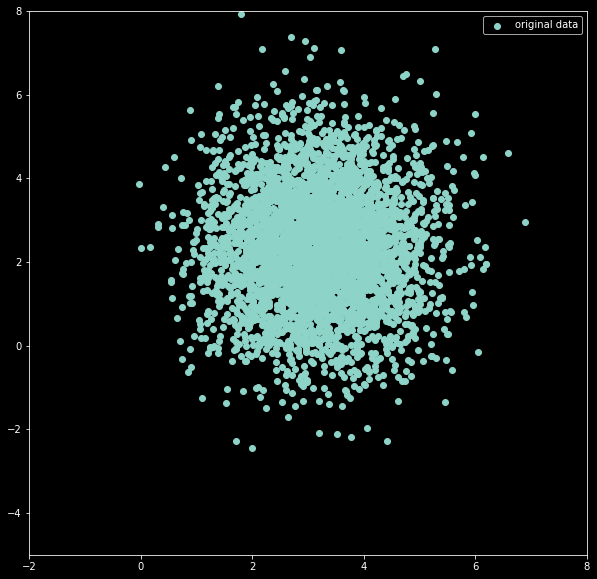

In [ ]:
import scipy.stats as sps
# Parameters of the gaussian
y_mu = np.array([4,2])
y_cov = np.diag(np.array([1,2]))

# Noise model 
y_var = 0.5

y = sps.multivariate_normal.rvs(mean=y_mu,cov=y_cov, size=4000) + np.random.multivariate_normal(np.zeros(2), y_var**0.5 * np.eye(2))

# Plot original data
plt.figure(figsize=(10,10))
plt.xlim(-2,8)
plt.ylim(-5,8)
plt.scatter(y[:,0], y[:,1], label='original data')
plt.legend()
plt.show()

In [ ]:
D = 4
input_dim = 2
output_dim = 2

encoder = [
    Dense(input_dim, relu),
    Dense(50, relu),
    Dense(D, identity)
]

decoder = [
  Dense(D//2, relu),
  Dense(50, relu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 0.01,
    "max_iteration": 2000,
    "S" : 5
}

vae = VAE(encoder, decoder)
optimization_state = vae.fit(optimization_params, y)
    
# Prior
mu_z = np.zeros(D//2)
sigma_z = np.eye(D//2) 

Optimization params:
step_size: 0.01
max_iteration: 2000
check_point: 100
S: 5 

Iteration 0 lower bound -974.5720298495278 in 0:00:00.041785.
Iteration 100 lower bound -66.86277254731033 in 0:00:02.826776.
Iteration 200 lower bound -5.72850454548162 in 0:00:02.791460.
Iteration 300 lower bound -4.299263673452945 in 0:00:02.751810.
Iteration 400 lower bound -3.921475038765358 in 0:00:02.766701.
Iteration 500 lower bound -3.6990044719304316 in 0:00:02.779571.
Iteration 600 lower bound -3.531198042724512 in 0:00:02.802468.
Iteration 700 lower bound -3.4102640290529225 in 0:00:02.791100.
Iteration 800 lower bound -3.3654313693457834 in 0:00:02.803655.
Iteration 900 lower bound -3.3022182817193544 in 0:00:02.803612.
Iteration 1000 lower bound -3.2644905660437527 in 0:00:02.900586.
Iteration 1100 lower bound -3.269249393489539 in 0:00:02.830434.
Iteration 1200 lower bound -3.2505256676669196 in 0:00:02.800892.
Iteration 1300 lower bound -3.2590013103943987 in 0:00:02.824366.
Iteration 1400 

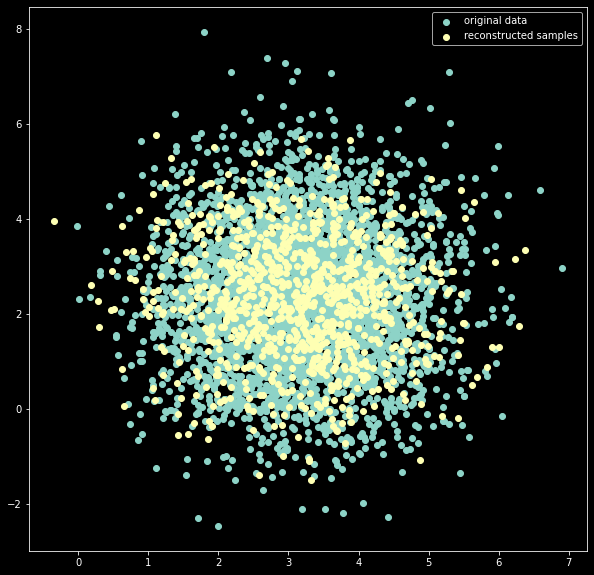

In [ ]:
ys = vae.generate(1000)
plt.figure(figsize=(10,10))
plt.scatter(y[:,0], y[:,1], label='original data')
plt.scatter(ys[:,0], ys[:,1], label='reconstructed samples')
plt.legend()
plt.show()

## Accelerated VAE

In [ ]:
D = 4
input_dim = 2
output_dim = 2

encoder = [
    Dense(input_dim, jrelu),
    Dense(50, jrelu),
    Dense(D, identity)
]

decoder = [
  Dense(D//2, jrelu),
  Dense(50, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 0.01,
    "max_iteration": 2000,
    "S" : 5
}

accelerated_vae = AcceleratedVAE(encoder, decoder)
optimization_state = accelerated_vae.fit(optimization_params, y)
    
# Prior
mu_z = np.zeros(D//2)
sigma_z = np.eye(D//2) 

Optimization params:
step_size: 0.01
max_iteration: 2000
check_point: 100
S: 5 

[epoch=0] elbo=-960.799072265625 in 0:00:03.397011.
[epoch=100] elbo=-18.69098663330078 in 0:00:01.046937.
[epoch=200] elbo=-5.896256446838379 in 0:00:00.125104.
[epoch=300] elbo=-5.013806343078613 in 0:00:00.138110.
[epoch=400] elbo=-4.426617622375488 in 0:00:00.132707.
[epoch=500] elbo=-4.153967380523682 in 0:00:00.129782.
[epoch=600] elbo=-3.980526924133301 in 0:00:00.125516.
[epoch=700] elbo=-3.847130298614502 in 0:00:00.126650.
[epoch=800] elbo=-3.8360748291015625 in 0:00:00.126487.
[epoch=900] elbo=-3.750960350036621 in 0:00:00.128882.
[epoch=1000] elbo=-3.662628650665283 in 0:00:00.125841.
[epoch=1100] elbo=-3.6489248275756836 in 0:00:00.128319.
[epoch=1200] elbo=-3.541757345199585 in 0:00:00.128556.
[epoch=1300] elbo=-3.4705328941345215 in 0:00:00.127248.
[epoch=1400] elbo=-3.4635977745056152 in 0:00:00.129695.
[epoch=1500] elbo=-3.380645513534546 in 0:00:00.132473.
[epoch=1600] elbo=-3.40961456298

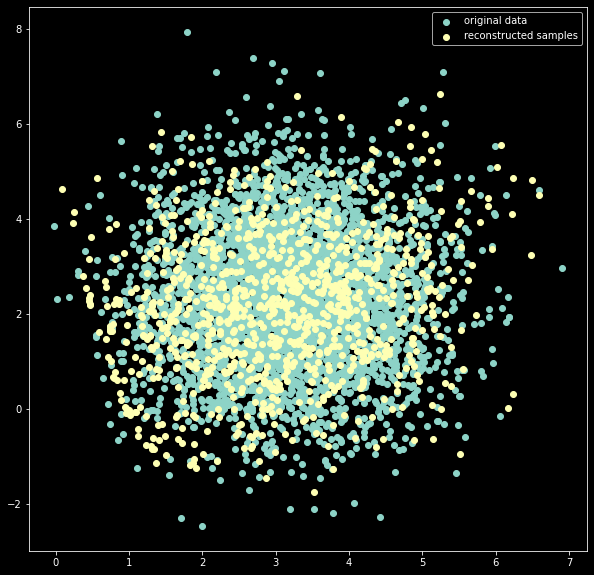

In [ ]:
zs = np.random.multivariate_normal(mu_z, sigma_z, size=1000)
ys =  accelerated_vae.decode(zs.T).T

plt.figure(figsize=(10,10))
plt.scatter(y[:,0], y[:,1], label='original data')
plt.scatter(ys[:,0], ys[:,1], label='reconstructed samples')
plt.legend()
plt.show()

# VAE 2: Mixture of Gaussians
<a class='anchor' id='vae2'></a>

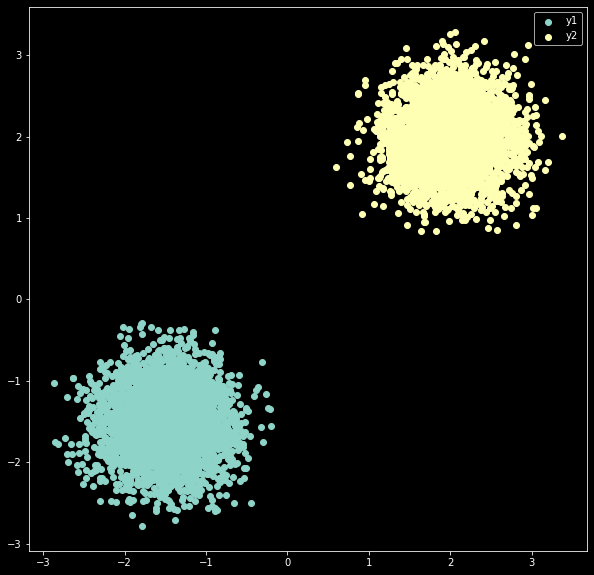

In [ ]:
import scipy.stats as sps
y_var = 1e-2
y1_mu = np.array([-1.5,-1.5])
y1_cov = np.diag(np.array([0.05,0.05]))
y1 = sps.multivariate_normal.rvs(mean=y1_mu,cov=y1_cov, size=4000) + np.random.multivariate_normal(np.zeros(2), y_var**0.5 * np.eye(2), size=4000)

y2_mu = np.array([2,2])
y2_cov = np.diag(np.array([0.05,0.05]))
y2 = sps.multivariate_normal.rvs(mean=y2_mu,cov=y2_cov, size=4000) + np.random.multivariate_normal(np.zeros(2), y_var**0.5 * np.eye(2), size=4000)

y = np.concatenate([y1,y2])
y_cov = y1_cov

plt.figure(figsize=(10,10))
# plt.xlim(-4,14)
# plt.ylim(-6,8)
plt.scatter(y1[:,0], y1[:,1], label='y1')
plt.scatter(y2[:,0], y2[:,1], label='y2')
plt.legend()
plt.show()

In [ ]:
D = 4
input_dim = 2
output_dim = 2

mix_encoder = [
    Dense(input_dim, jrelu),
    Dense(50, jrelu),
    Dense(D, identity)
]

mix_decoder = [
  Dense(D//2, jrelu),
  Dense(50, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 1e-3,
    "max_iteration": 12000,
    "S": 2
}

mixture_vae = AcceleratedVAE(mix_encoder, mix_decoder)
optimization_state = mixture_vae.fit(optimization_params, y)

Optimization params:
step_size: 0.001
max_iteration: 12000
check_point: 100
S: 2 

[epoch=0] elbo=-327.451904296875 in 0:00:01.898927.
[epoch=100] elbo=-82.44242095947266 in 0:00:00.900515.
[epoch=200] elbo=-15.07210636138916 in 0:00:00.127895.
[epoch=300] elbo=-13.468086242675781 in 0:00:00.128783.
[epoch=400] elbo=-12.328088760375977 in 0:00:00.128275.
[epoch=500] elbo=-11.432294845581055 in 0:00:00.127469.
[epoch=600] elbo=-10.757144927978516 in 0:00:00.125112.
[epoch=700] elbo=-10.126924514770508 in 0:00:00.123443.
[epoch=800] elbo=-9.69041633605957 in 0:00:00.126247.
[epoch=900] elbo=-9.357526779174805 in 0:00:00.131369.
[epoch=1000] elbo=-9.125539779663086 in 0:00:00.129010.
[epoch=1100] elbo=-8.880681037902832 in 0:00:00.126185.
[epoch=1200] elbo=-8.74545669555664 in 0:00:00.124378.
[epoch=1300] elbo=-8.609320640563965 in 0:00:00.126933.
[epoch=1400] elbo=-8.534697532653809 in 0:00:00.124347.
[epoch=1500] elbo=-8.488737106323242 in 0:00:00.122934.
[epoch=1600] elbo=-8.4227561950

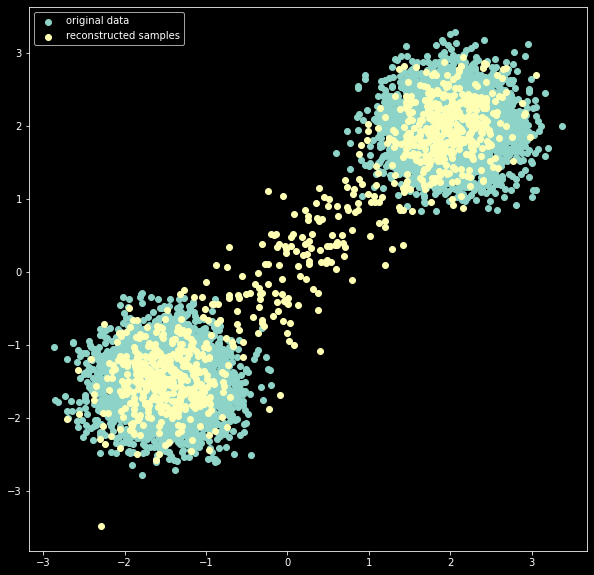

In [ ]:
ys = mixture_vae.generate(1000)

plt.figure(figsize=(10,10))
plt.scatter(y[:,0], y[:,1], label='original data')
plt.scatter(ys[:,0], ys[:,1], label='reconstructed samples')
plt.legend()
plt.show()

# VAE 3: Simple fake loan data
<a class='anchor' id='vae3'></a>

In [ ]:
fake_loan_3var_csv_path = f"{data_path}/FakeLoan_3var/fakeloan_3var_train.csv"
fake_loan_3var_df = pd.read_csv(fake_loan_3var_csv_path)
fake_loan_3var_df.head()

,fico,ltv,age,default
0,561.009373,1.225528,34.485286,0.0
1,697.738447,0.976093,49.146389,0.0
2,445.483818,1.262363,35.485068,0.0
3,648.451446,1.194041,45.494172,0.0
4,502.785433,0.975546,33.580883,0.0


In [ ]:
fake_loan_3var_df.drop(columns=['default'], inplace=True)
fake_loan_3var_df.head()

,fico,ltv,age
0,561.009373,1.225528,34.485286
1,697.738447,0.976093,49.146389
2,445.483818,1.262363,35.485068
3,648.451446,1.194041,45.494172
4,502.785433,0.975546,33.580883


In [ ]:
fake_loan_3var_loan_data =  fake_loan_3var_df.to_numpy()
fake_loan_3var_loan_data.shape

(4000, 3)

In [ ]:
# Preprocess the loan data
# Apply standard scaling to train & test
# Training Data
fakeloan_3var_sc = StandardScaler()
fake_loan_3var_data_standardized = fakeloan_3var_sc.fit_transform(fake_loan_3var_loan_data)

In [ ]:
D = 4
input_dim = 3
output_dim = 3

fake_loan_3var_encoder = [
    Dense(input_dim, jrelu),    
    Dense(512, jrelu),
    Dense(256, jrelu),
    Dense(D, identity)
]

fake_loan_3var_decoder = [
  Dense(D//2, jrelu),
  Dense(512, jrelu),
  Dense(256, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 1e-4,
    "max_iteration": 25000,
    "S": 1
}


fake_loan_3var_vae = AcceleratedVAE(fake_loan_3var_encoder, fake_loan_3var_decoder)
optimization_state = fake_loan_3var_vae.fit(optimization_params, fake_loan_3var_data_standardized)

Optimization params:
step_size: 0.0001
max_iteration: 25000
check_point: 100
S: 1 

[epoch=0] elbo=-146.0581512451172 in 0:00:02.192911.
[epoch=100] elbo=-77.27613830566406 in 0:00:01.575187.
[epoch=200] elbo=-36.549896240234375 in 0:00:00.290791.
[epoch=300] elbo=-33.764225006103516 in 0:00:00.292855.
[epoch=400] elbo=-32.25009536743164 in 0:00:00.294189.
[epoch=500] elbo=-30.941896438598633 in 0:00:00.289417.
[epoch=600] elbo=-29.560604095458984 in 0:00:00.289852.
[epoch=700] elbo=-28.067373275756836 in 0:00:00.293491.
[epoch=800] elbo=-26.520416259765625 in 0:00:00.290897.
[epoch=900] elbo=-24.68253517150879 in 0:00:00.293711.
[epoch=1000] elbo=-23.274394989013672 in 0:00:00.290859.
[epoch=1100] elbo=-22.045358657836914 in 0:00:00.293138.
[epoch=1200] elbo=-21.129680633544922 in 0:00:00.286677.
[epoch=1300] elbo=-20.308320999145508 in 0:00:00.292745.
[epoch=1400] elbo=-19.844247817993164 in 0:00:00.291721.
[epoch=1500] elbo=-19.201141357421875 in 0:00:00.288221.
[epoch=1600] elbo=-1

In [ ]:
y_samples =  fakeloan_3var_sc.inverse_transform(
  fake_loan_3var_vae.generate(10000)
)

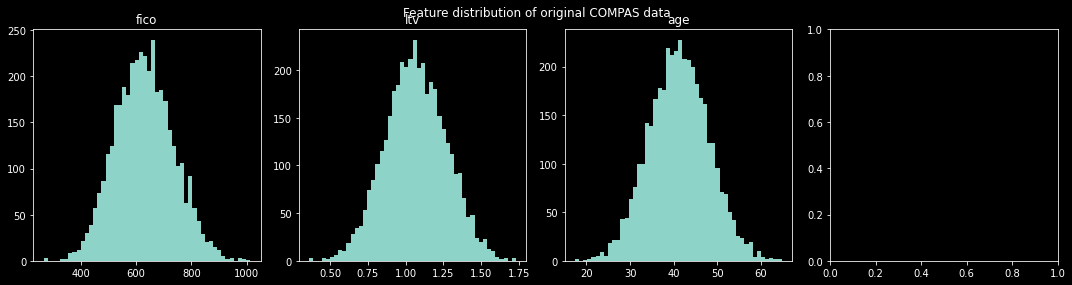

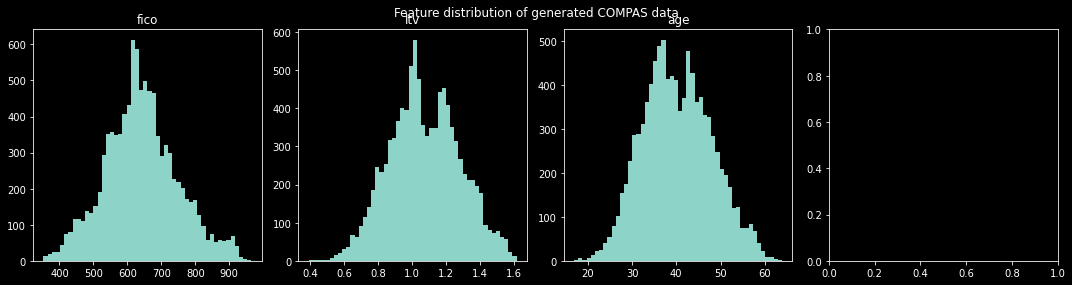

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
axes = ax.ravel()

for feature_index, feature in enumerate(fake_loan_3var_df.columns):
  axis = axes[feature_index]
  axis.hist(fake_loan_3var_loan_data[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of original COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()


fig, ax = plt.subplots(1, 4, figsize=(15, 4))
axes = ax.ravel()

for feature_index, feature in enumerate(fake_loan_3var_df.columns):
  axis = axes[feature_index]
  axis.hist(y_samples[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of generated COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

### Pickle the weights

In [ ]:
filename = f"{parameter_path}/FakeLoan_3var/loan_3var_vae_D_{D}.weights"
pickle_vae_weights(fake_loan_3var_vae, filename)

### Save the architecture

In [ ]:
filename = f"{parameter_path}/FakeLoan_3var/loan_3var_vae_D_{D}_architecture.txt"
save_architecture(fake_loan_3var_vae.encoder, fake_loan_3var_vae.decoder, D, filename)

# VAE 4: Loan data
<a class='anchor' id='vae4'></a>

In [ ]:
loan_csv_path = f"{data_path}/FakeLoan/fakeloan_train.csv"
loan_df = pd.read_csv(loan_csv_path)
loan_df.head()

,fico,term,pti,ltv,age,default
0,608.478049,5.746497,0.090860,1.176882,42.977394,0.0
1,765.299358,6.248005,0.042730,1.067076,35.664270,0.0
2,597.166685,4.075591,0.100311,1.044465,38.161854,0.0
3,497.201395,5.497482,0.172394,0.869360,35.172708,1.0
4,739.595885,4.974255,0.150318,1.017501,32.119817,0.0


In [ ]:
loan_df.drop(columns=['default'], inplace=True)
loan_df.head()

,fico,term,pti,ltv,age
0,608.478049,5.746497,0.090860,1.176882,42.977394
1,765.299358,6.248005,0.042730,1.067076,35.664270
2,597.166685,4.075591,0.100311,1.044465,38.161854
3,497.201395,5.497482,0.172394,0.869360,35.172708
4,739.595885,4.974255,0.150318,1.017501,32.119817


In [ ]:
loan_df.describe()

,fico,term,pti,ltv,age
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,629.983488,6.088628,0.104134,1.069451,41.411232
std,102.207626,0.976085,0.050279,0.204036,6.962852
min,206.687374,2.087296,-0.092970,0.291304,16.298686
25%,557.426122,5.448406,0.069793,0.932175,36.688661
50%,628.996833,6.116425,0.104864,1.069795,41.317247
75%,699.842806,6.759562,0.137921,1.205825,46.110519
max,1049.220796,9.654949,0.284686,1.804784,69.093035


In [ ]:
loan_data =  loan_df.to_numpy()
loan_data.shape

(8000, 5)

In [ ]:
# Preprocess the loan data
# Apply standard scaling to train & test
# Training Data
sc = StandardScaler()
loan_data_standardized = sc.fit_transform(loan_data)

In [ ]:
D = 8
input_dim = 5
output_dim = 5

loan_encoder = [
    Dense(input_dim, jrelu),    
    Dense(128, jrelu),
    Dense(128, jrelu),
    Dense(D, identity)
]

loan_decoder = [
  Dense(D//2, jrelu),
  Dense(128, jrelu),
  Dense(128, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 1e-4,
    "max_iteration": 25000,
    "S": 1
}


loan_vae = AcceleratedVAE(loan_encoder, loan_decoder)
optimization_state = loan_vae.fit(optimization_params, loan_data_standardized)

Optimization params:
step_size: 0.0001
max_iteration: 25000
check_point: 100
S: 1 

[epoch=0] elbo=-243.64256286621094 in 0:00:02.434044.
[epoch=100] elbo=-239.83827209472656 in 0:00:01.415459.
[epoch=200] elbo=-172.99594116210938 in 0:00:00.223444.
[epoch=300] elbo=-158.6920166015625 in 0:00:00.225515.
[epoch=400] elbo=-115.5242919921875 in 0:00:00.225770.
[epoch=500] elbo=-80.40771484375 in 0:00:00.228240.
[epoch=600] elbo=-77.15939331054688 in 0:00:00.219872.
[epoch=700] elbo=-71.27789306640625 in 0:00:00.225411.
[epoch=800] elbo=-45.18613815307617 in 0:00:00.226199.
[epoch=900] elbo=-40.72454071044922 in 0:00:00.227474.
[epoch=1000] elbo=-37.98026657104492 in 0:00:00.228837.
[epoch=1100] elbo=-36.534629821777344 in 0:00:00.226345.
[epoch=1200] elbo=-35.78777313232422 in 0:00:00.222232.
[epoch=1300] elbo=-35.2403564453125 in 0:00:00.228032.
[epoch=1400] elbo=-34.851783752441406 in 0:00:00.224523.
[epoch=1500] elbo=-34.574588775634766 in 0:00:00.222402.
[epoch=1600] elbo=-34.16714859

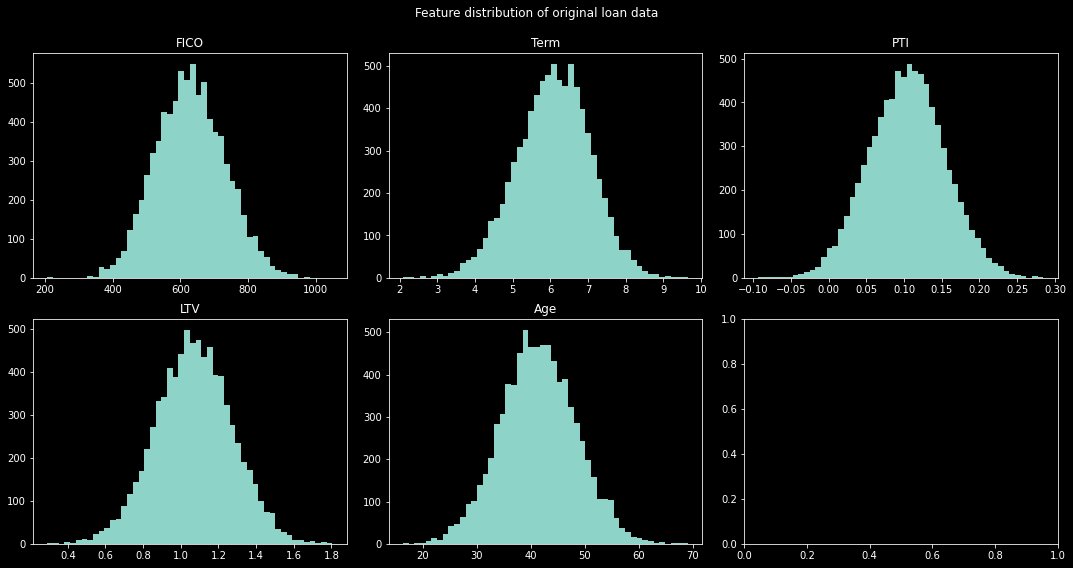

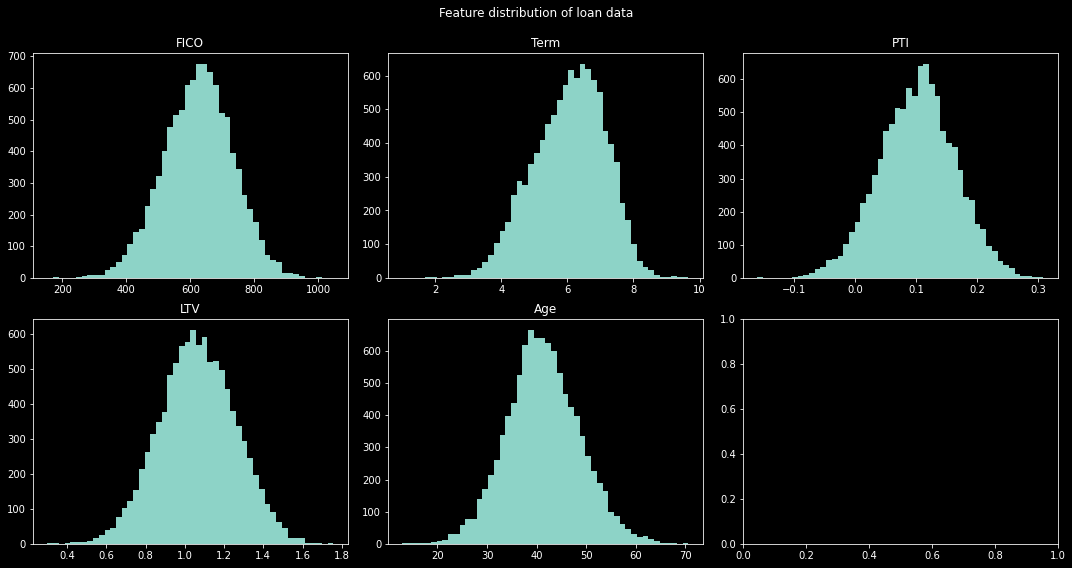

In [ ]:
y_samples =  sc.inverse_transform(
  loan_vae.generate(10000)
)

# Plot original (fake) loan data generated by the VAE
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0,0].hist(loan_data[:,0], bins=50)
ax[0,0].set_title('FICO')
ax[0,1].hist(loan_data[:,1], bins=50)
ax[0,1].set_title('Term')
ax[0,2].hist(loan_data[:,2], bins=50)
ax[0,2].set_title('PTI')  
ax[1,0].hist(loan_data[:,3], bins=50)
ax[1,0].set_title('LTV')
ax[1,1].hist(loan_data[:,4], bins=50)
ax[1,1].set_title('Age')
plt.suptitle("Feature distribution of original loan data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

# Plot some sample loan data generated by the VAE
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0,0].hist(y_samples[:,0], bins=50)
ax[0,0].set_title('FICO')
ax[0,1].hist(y_samples[:,1], bins=50)
ax[0,1].set_title('Term')
ax[0,2].hist(y_samples[:,2], bins=50)
ax[0,2].set_title('PTI')  
ax[1,0].hist(y_samples[:,3], bins=50)
ax[1,0].set_title('LTV')
ax[1,1].hist(y_samples[:,4], bins=50)
ax[1,1].set_title('Age')
plt.suptitle("Feature distribution of loan data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

### Pickle the weights

In [ ]:
filename = f"{parameter_path}/FakeLoan/loan_vae_D_{D}.weights"

pickle_vae_weights(loan_vae, filename)

### Save the architecture

In [ ]:
filename = f"{parameter_path}/FakeLoan/loan_vae_D_{D}_architecture.txt"
save_architecture(loan_vae.encoder, loan_vae.decoder, D, filename)

# VAE 5: COMPAS data
<a class='anchor' id='vae5'></a>

In [ ]:
compas_path = f"{data_path}/COMPAS/compas_train.csv"
compas_df = pd.read_csv(compas_path)
compas_df.head()

,age,race,sex,priors_count,c_charge_degree,days_served,two_year_recid
0,26.0,0.0,1.0,9.0,1.0,1.89,1.0
1,68.0,1.0,1.0,0.0,1.0,3.18,0.0
2,35.0,0.0,1.0,0.0,0.0,1.03,0.0
3,21.0,1.0,1.0,0.0,1.0,1.02,0.0
4,35.0,0.0,0.0,2.0,0.0,14.13,0.0


In [ ]:
compas_df.drop(columns='two_year_recid', inplace=True)
compas_df.head()

,age,race,sex,priors_count,c_charge_degree,days_served
0,26.0,0.0,1.0,9.0,1.0,1.89
1,68.0,1.0,1.0,0.0,1.0,3.18
2,35.0,0.0,1.0,0.0,0.0,1.03
3,21.0,1.0,1.0,0.0,1.0,1.02
4,35.0,0.0,0.0,2.0,0.0,14.13


In [ ]:
compas_df.describe()

,age,race,sex,priors_count,c_charge_degree,days_served
count,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000,4524.000000
mean,34.467728,0.396110,0.805703,3.490716,0.349027,15.613499
std,11.723907,0.489142,0.395702,4.900031,0.476715,47.603294
min,18.000000,0.000000,0.000000,0.000000,0.000000,-0.490000
25%,25.000000,0.000000,1.000000,0.000000,0.000000,0.890000
50%,31.000000,0.000000,1.000000,2.000000,0.000000,1.210000
75%,42.000000,1.000000,1.000000,5.000000,1.000000,6.142500
max,80.000000,1.000000,1.000000,38.000000,1.000000,799.790000


In [ ]:
feature_count = len(compas_df.columns)
print(f"Data has {feature_count} features.")

Data has 6 features.


In [ ]:
compas_data = compas_df.to_numpy()

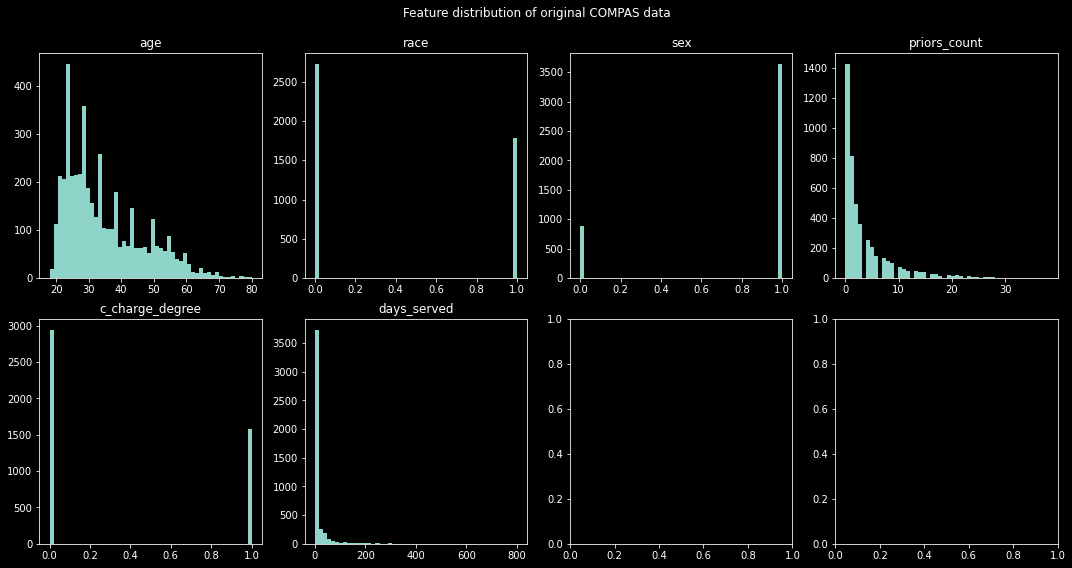

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(compas_data[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of original COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

In [ ]:
# Preprocess the COMPAS data
# Apply standard scaling to train & test
# Training Data
compas_sc = StandardScaler()
compas_data_standardized = compas_sc.fit_transform(compas_data)

In [ ]:
D = 6
input_dim = feature_count
output_dim = feature_count

compas_encoder = [
    Dense(input_dim, jrelu),    
    Dense(128, jrelu),
    Dense(128, jrelu),
    Dense(D, identity)
]

compas_decoder = [
  Dense(D//2, jrelu),
  Dense(128, jrelu),
  Dense(128, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 1e-4,
    "max_iteration": 25000,
    "S": 1
}


compas_vae = AcceleratedVAE(compas_encoder, compas_decoder)
optimization_state = compas_vae.fit(optimization_params, compas_data_standardized)

Optimization params:
step_size: 0.0001
max_iteration: 25000
check_point: 100
S: 1 

[epoch=0] elbo=-291.9151611328125 in 0:00:02.549874.
[epoch=100] elbo=-288.390869140625 in 0:00:01.281296.
[epoch=200] elbo=-224.8142852783203 in 0:00:00.188739.
[epoch=300] elbo=-175.99951171875 in 0:00:00.178623.
[epoch=400] elbo=-140.99310302734375 in 0:00:00.187268.
[epoch=500] elbo=-110.06309509277344 in 0:00:00.172567.
[epoch=600] elbo=-62.635169982910156 in 0:00:00.174223.
[epoch=700] elbo=-44.39205551147461 in 0:00:00.187104.
[epoch=800] elbo=-36.339908599853516 in 0:00:00.183539.
[epoch=900] elbo=-30.28121566772461 in 0:00:00.184763.
[epoch=1000] elbo=-26.041797637939453 in 0:00:00.188584.
[epoch=1100] elbo=-23.349870681762695 in 0:00:00.178613.
[epoch=1200] elbo=-21.203231811523438 in 0:00:00.183912.
[epoch=1300] elbo=-19.193435668945312 in 0:00:00.187691.
[epoch=1400] elbo=-17.455677032470703 in 0:00:00.180480.
[epoch=1500] elbo=-15.91884994506836 in 0:00:00.185838.
[epoch=1600] elbo=-14.6199

In [ ]:
y_samples =  compas_sc.inverse_transform(
  compas_vae.generate(10000)
)

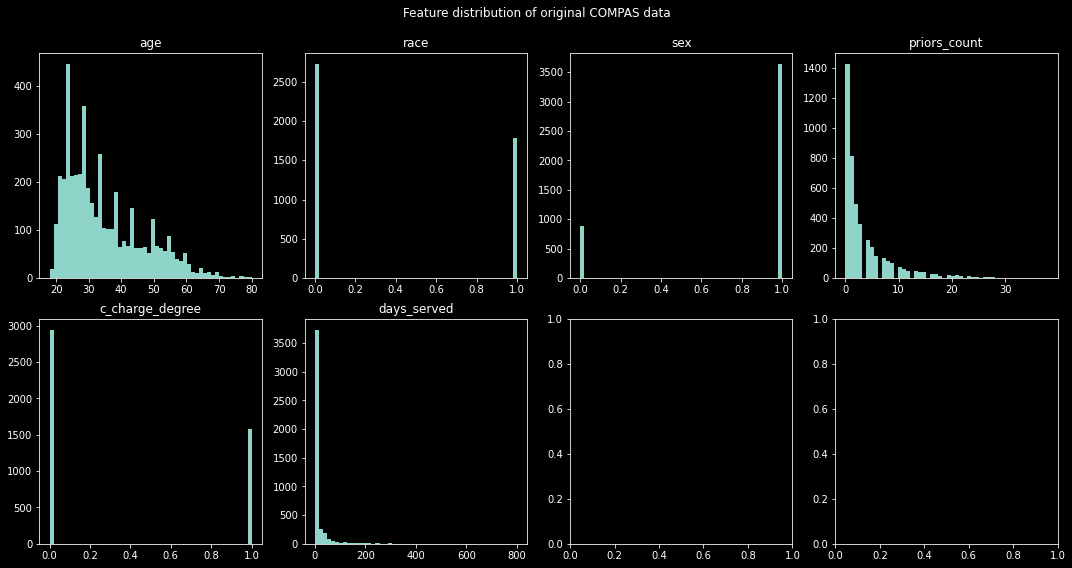

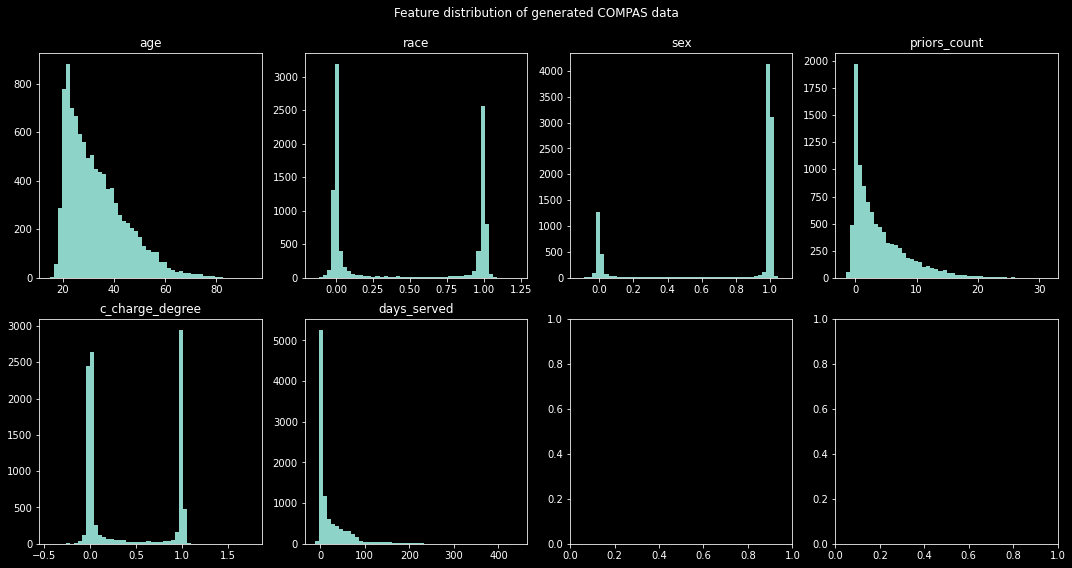

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(compas_data[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of original COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()


fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(y_samples[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of generated COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

#### Pickle the weights

In [ ]:
filename = f"{parameter_path}/COMPAS/compas_vae_D_{D}_.weights"
pickle_vae_weights(compas_vae, filename)

### Save the architecture

In [ ]:
filename = f"{parameter_path}/COMPAS/compas_vae_D_{D}_architecture.txt"
save_architecture(compas_vae.encoder, compas_vae.decoder, D, filename)

### Pickle the weights (+testing the pickling/unpickling process)

(The pickling was written at the end, so the test is also at the end)

In [ ]:
filename = f"{parameter_path}/COMPAS/compas_vae_D_{D}_.weights"
encoder_weights, decoder_weights = unpickle_vae_weights(filename)

# Reconstruct VAE
unpickled_compas_vae = VAE(
    compas_encoder, 
    compas_decoder,
    encoder_weights,
    decoder_weights
)

# Generate some data to plot
y_samples = compas_sc.inverse_transform(
  unpickled_compas_vae.generate(10000)
)

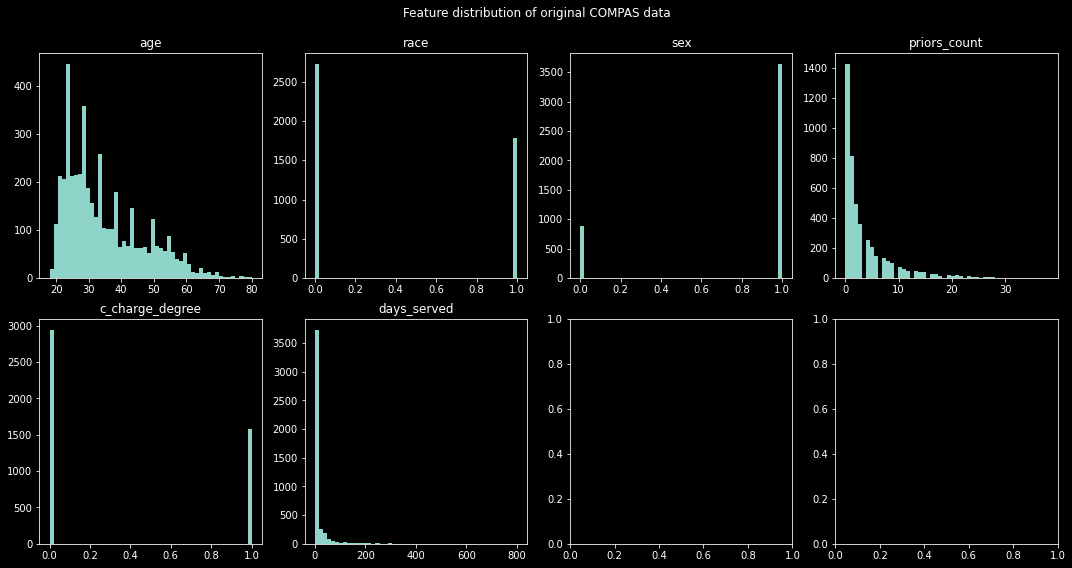

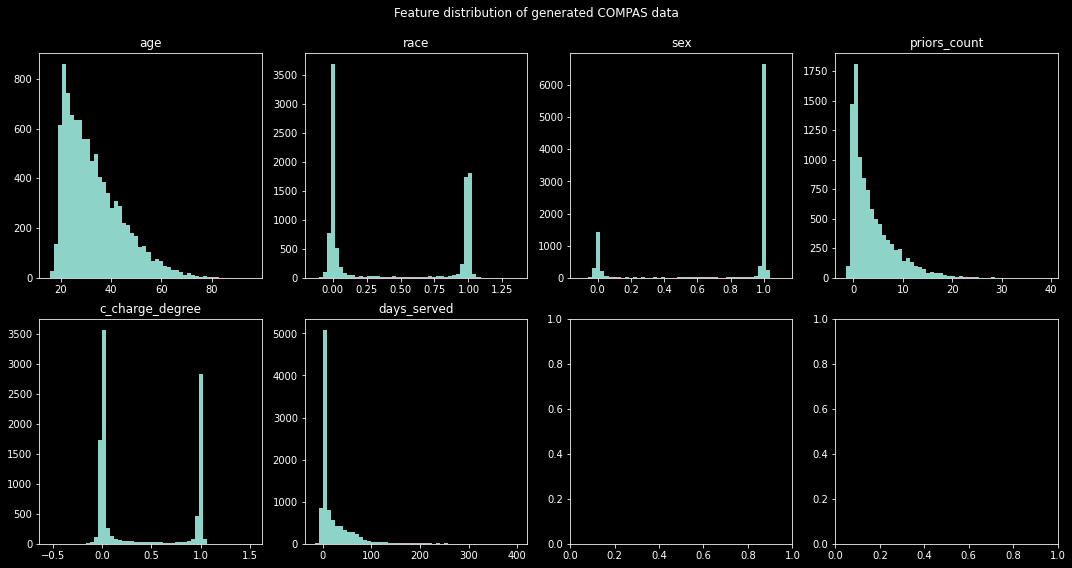

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(compas_data[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of original COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()


fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(y_samples[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of generated COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

# VAE 6: Generated Loan data
<a class='anchor' id='vae6'></a>

In [ ]:
loan_csv_path = f"{data_path}/FakeLoan_generated/gen_loan_train_x.csv"
loan_df = pd.read_csv(loan_csv_path)
loan_df.head()

,Unnamed: 0,fico,term,pti,ltv,age
0,0,771.38434,5.914379,0.062804,1.181167,45.652824
1,1,829.89020,5.815327,0.120413,1.221888,36.459377
2,2,607.40790,5.214087,0.130817,1.191535,37.548164
3,3,574.95490,6.137321,0.113409,1.124937,42.064750
4,4,446.36697,6.631861,0.158949,1.195639,52.985590


In [ ]:
loan_df.drop(columns=loan_df.columns[0], inplace=True)
loan_df.head()

,fico,term,pti,ltv,age
0,771.38434,5.914379,0.062804,1.181167,45.652824
1,829.89020,5.815327,0.120413,1.221888,36.459377
2,607.40790,5.214087,0.130817,1.191535,37.548164
3,574.95490,6.137321,0.113409,1.124937,42.064750
4,446.36697,6.631861,0.158949,1.195639,52.985590


In [ ]:
loan_df.describe()

,fico,term,pti,ltv,age
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,622.362578,6.201788,0.104962,1.073744,41.554423
std,95.282641,0.966874,0.050751,0.205781,7.398677
min,248.924710,1.807116,-0.101250,0.215211,16.678278
25%,559.376475,5.557233,0.071904,0.937463,36.535096
50%,620.264300,6.225756,0.105388,1.073165,41.550772
75%,683.550950,6.889213,0.139844,1.212669,46.431733
max,984.178470,9.401728,0.274942,1.858833,71.211690


In [ ]:
loan_data =  loan_df.to_numpy()
loan_data.shape

(10000, 5)

In [ ]:
# Preprocess the loan data
# Apply standard scaling to train & test
# Training Data
sc = StandardScaler()
loan_data_standardized = sc.fit_transform(loan_data)

In [ ]:
D = 6
input_dim = 5
output_dim = 5

loan_encoder = [
    Dense(input_dim, jrelu),    
    Dense(128, jrelu),
    Dense(128, jrelu),
    Dense(D, identity)
]

loan_decoder = [
  Dense(D//2, jrelu),
  Dense(128, jrelu),
  Dense(128, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 1e-4,
    "max_iteration": 25000,
    "S": 1
}


loan_vae = AcceleratedVAE(loan_encoder, loan_decoder)
optimization_state = loan_vae.fit(optimization_params, loan_data_standardized)

Optimization params:
step_size: 0.0001
max_iteration: 25000
check_point: 100
S: 1 

[epoch=0] elbo=-244.58853149414062 in 0:00:02.222365.
[epoch=100] elbo=-241.0120086669922 in 0:00:01.584437.
[epoch=200] elbo=-197.97238159179688 in 0:00:00.244854.
[epoch=300] elbo=-151.48745727539062 in 0:00:00.245248.
[epoch=400] elbo=-129.33668518066406 in 0:00:00.247745.
[epoch=500] elbo=-89.6777572631836 in 0:00:00.240882.
[epoch=600] elbo=-84.33789825439453 in 0:00:00.246770.
[epoch=700] elbo=-82.27850341796875 in 0:00:00.244102.
[epoch=800] elbo=-80.43343353271484 in 0:00:00.243757.
[epoch=900] elbo=-78.71055603027344 in 0:00:00.244068.
[epoch=1000] elbo=-77.3232421875 in 0:00:00.242820.
[epoch=1100] elbo=-76.07829284667969 in 0:00:00.243006.
[epoch=1200] elbo=-74.8342514038086 in 0:00:00.240152.
[epoch=1300] elbo=-73.50454711914062 in 0:00:00.240777.
[epoch=1400] elbo=-72.07140350341797 in 0:00:00.241314.
[epoch=1500] elbo=-70.63833618164062 in 0:00:00.241048.
[epoch=1600] elbo=-69.019126892089

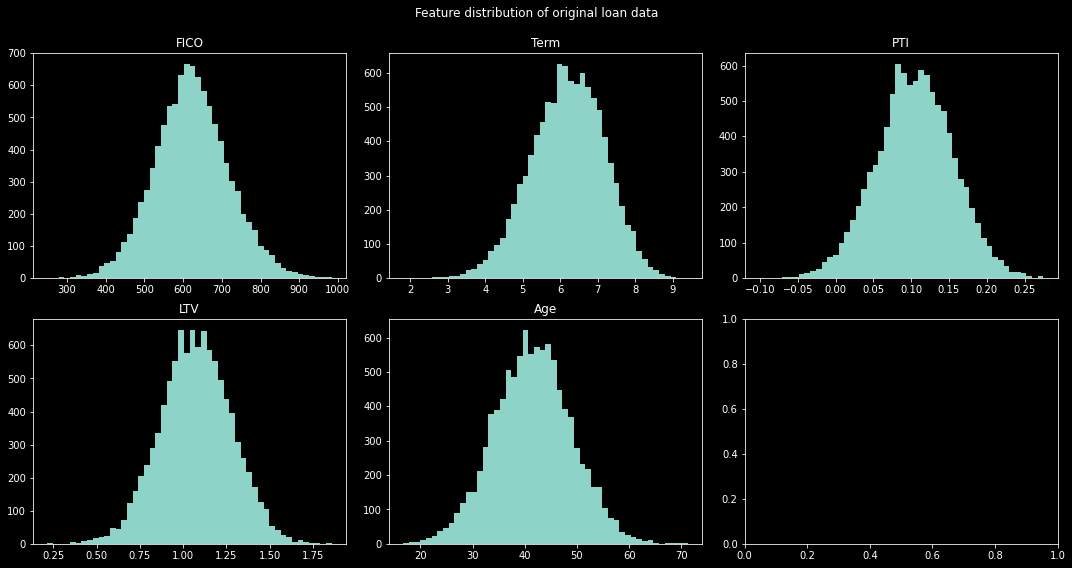

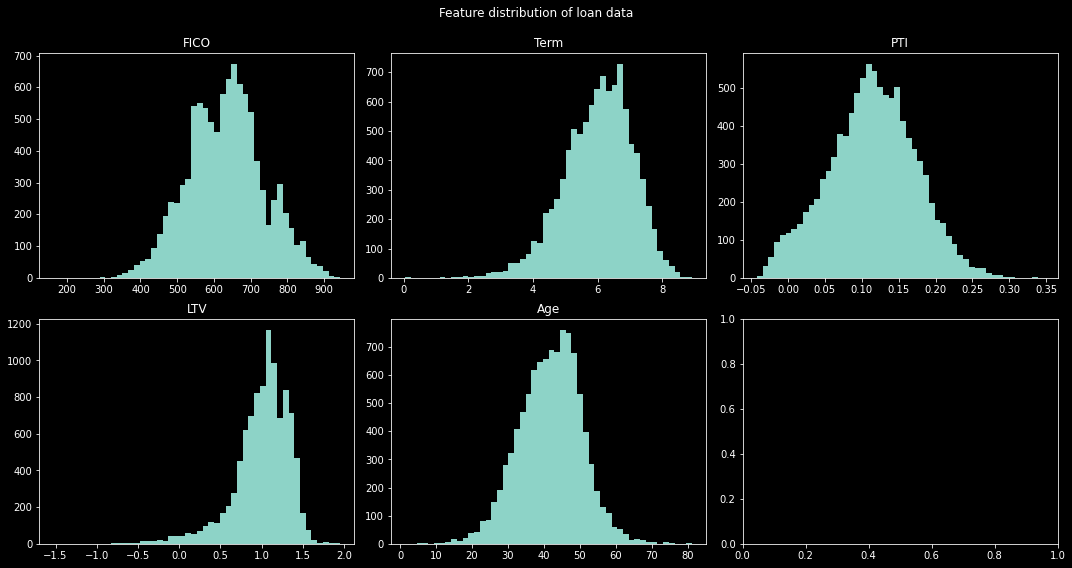

In [ ]:
y_samples =  sc.inverse_transform(
  loan_vae.generate(10000)
)

# Plot original (fake) loan data generated by the VAE
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0,0].hist(loan_data[:,0], bins=50)
ax[0,0].set_title('FICO')
ax[0,1].hist(loan_data[:,1], bins=50)
ax[0,1].set_title('Term')
ax[0,2].hist(loan_data[:,2], bins=50)
ax[0,2].set_title('PTI')  
ax[1,0].hist(loan_data[:,3], bins=50)
ax[1,0].set_title('LTV')
ax[1,1].hist(loan_data[:,4], bins=50)
ax[1,1].set_title('Age')
plt.suptitle("Feature distribution of original loan data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

# Plot some sample loan data generated by the VAE
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0,0].hist(y_samples[:,0], bins=50)
ax[0,0].set_title('FICO')
ax[0,1].hist(y_samples[:,1], bins=50)
ax[0,1].set_title('Term')
ax[0,2].hist(y_samples[:,2], bins=50)
ax[0,2].set_title('PTI')  
ax[1,0].hist(y_samples[:,3], bins=50)
ax[1,0].set_title('LTV')
ax[1,1].hist(y_samples[:,4], bins=50)
ax[1,1].set_title('Age')
plt.suptitle("Feature distribution of loan data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

### Pickle the weights

In [ ]:
filename = f"{parameter_path}/FakeLoan_generated/loan_vae_D_{D}.weights"
pickle_vae_weights(loan_vae, filename)

### Save the architecture

In [ ]:
filename = f"{parameter_path}/FakeLoan_generated/loan_vae_D_{D}_architecture.txt"
save_architecture(loan_vae.encoder, loan_vae.decoder, D, filename)

# VAE 7: Generated COMPAS data
<a class='anchor' id='vae7'></a>

In [ ]:
compas_path = f"{data_path}/COMPAS_generated/gen_compas_train_x.csv"
compas_df = pd.read_csv(compas_path)
compas_df.head()

,Unnamed: 0,age,race,sex,priors_count,c_charge_degree,days_served
0,0,42.297432,0.989538,0.999788,0.523008,0.001425,2.914387
1,1,21.815056,0.003711,0.997267,-0.066168,0.001860,1.303772
2,2,33.963608,1.002660,0.994385,1.187321,0.804268,0.613524
3,3,27.925790,0.001511,0.999817,2.113717,0.002235,2.785877
4,4,25.830725,-0.002826,0.614626,15.351144,0.995664,16.606804


In [ ]:
compas_df.drop(columns=compas_df.columns[0], inplace=True)
compas_df.head()

,age,race,sex,priors_count,c_charge_degree,days_served
0,42.297432,0.989538,0.999788,0.523008,0.001425,2.914387
1,21.815056,0.003711,0.997267,-0.066168,0.001860,1.303772
2,33.963608,1.002660,0.994385,1.187321,0.804268,0.613524
3,27.925790,0.001511,0.999817,2.113717,0.002235,2.785877
4,25.830725,-0.002826,0.614626,15.351144,0.995664,16.606804


In [ ]:
compas_df.describe()

,age,race,sex,priors_count,c_charge_degree,days_served
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,34.309132,0.398112,0.890247,3.509308,0.334193,11.041720
std,11.276113,0.459644,0.304989,4.521563,0.430001,26.408291
min,16.406464,-0.069146,-1.641056,-0.784036,-0.017844,-1.370397
25%,25.550542,-0.000035,0.994445,0.397924,0.000729,1.474526
50%,31.269849,0.012819,0.998505,1.829257,0.005423,2.486574
75%,40.932226,0.996565,1.000579,4.661417,0.889513,7.237059
max,85.789190,1.044255,1.025550,32.367480,1.225830,385.739380


In [ ]:
feature_count = len(compas_df.columns)
print(f"Data has {feature_count} features.")

Data has 6 features.


In [ ]:
compas_data = compas_df.to_numpy()

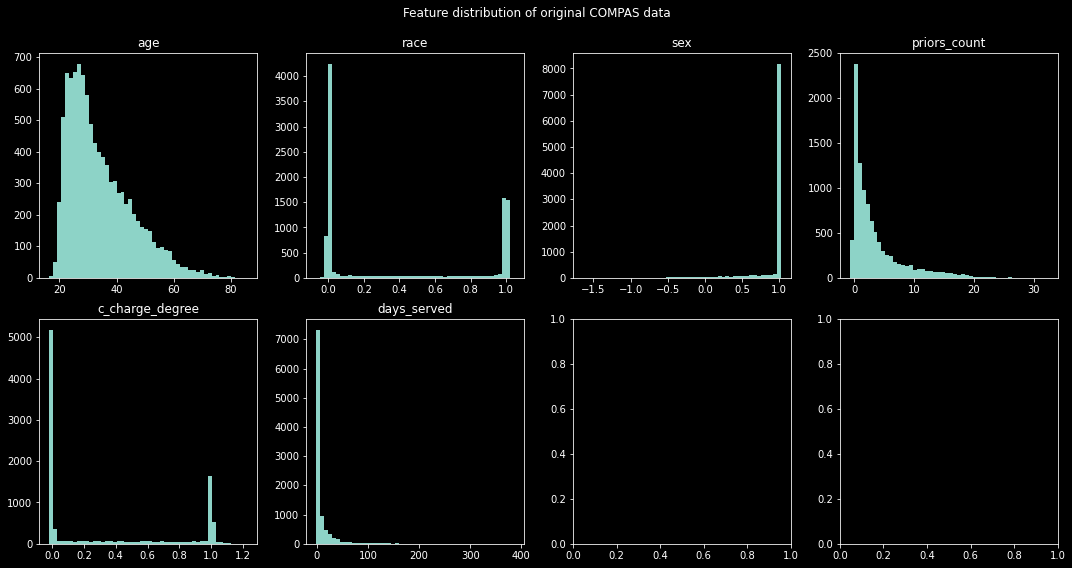

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(compas_data[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of original COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

In [ ]:
# Preprocess the COMPAS data
# Apply standard scaling to train & test
# Training Data
compas_sc = StandardScaler()
compas_data_standardized = compas_sc.fit_transform(compas_data)

In [ ]:
D = 6
input_dim = feature_count
output_dim = feature_count

compas_encoder = [
    Dense(input_dim, jrelu),    
    Dense(128, jrelu),
    Dense(128, jrelu),
    Dense(D, identity)
]

compas_decoder = [
  Dense(D//2, jrelu),
  Dense(128, jrelu),
  Dense(128, jrelu),
  Dense(output_dim, identity)
]

optimization_params = {
    "step_size": 1e-4,
    "max_iteration": 25000,
    "S": 1
}


compas_vae = AcceleratedVAE(compas_encoder, compas_decoder)
optimization_state = compas_vae.fit(optimization_params, compas_data_standardized)

Optimization params:
step_size: 0.0001
max_iteration: 25000
check_point: 100
S: 1 

[epoch=0] elbo=-291.83642578125 in 0:00:00.578217.
[epoch=100] elbo=-288.6692199707031 in 0:00:01.070043.
[epoch=200] elbo=-229.03587341308594 in 0:00:00.247532.
[epoch=300] elbo=-172.76499938964844 in 0:00:00.243553.
[epoch=400] elbo=-134.25062561035156 in 0:00:00.246928.
[epoch=500] elbo=-105.28543090820312 in 0:00:00.247067.
[epoch=600] elbo=-58.17854690551758 in 0:00:00.243496.
[epoch=700] elbo=-47.14670181274414 in 0:00:00.241701.
[epoch=800] elbo=-41.60594177246094 in 0:00:00.241891.
[epoch=900] elbo=-37.951236724853516 in 0:00:00.240947.
[epoch=1000] elbo=-35.3973274230957 in 0:00:00.244724.
[epoch=1100] elbo=-33.174415588378906 in 0:00:00.241310.
[epoch=1200] elbo=-31.259721755981445 in 0:00:00.240353.
[epoch=1300] elbo=-29.702754974365234 in 0:00:00.242871.
[epoch=1400] elbo=-28.327892303466797 in 0:00:00.242543.
[epoch=1500] elbo=-27.089374542236328 in 0:00:00.244544.
[epoch=1600] elbo=-25.867

In [ ]:
y_samples =  compas_sc.inverse_transform(
  compas_vae.generate(10000)
)

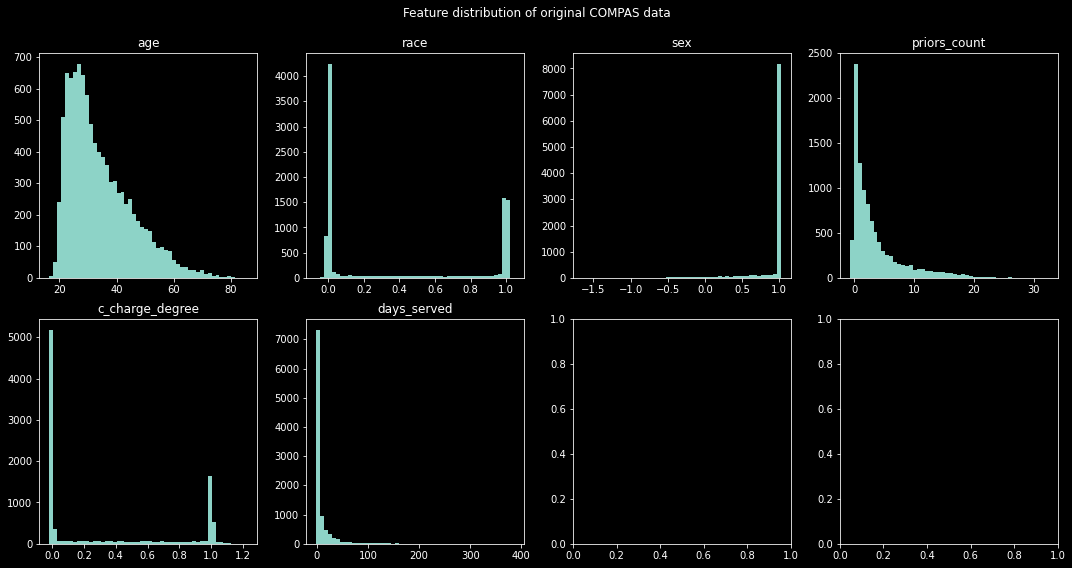

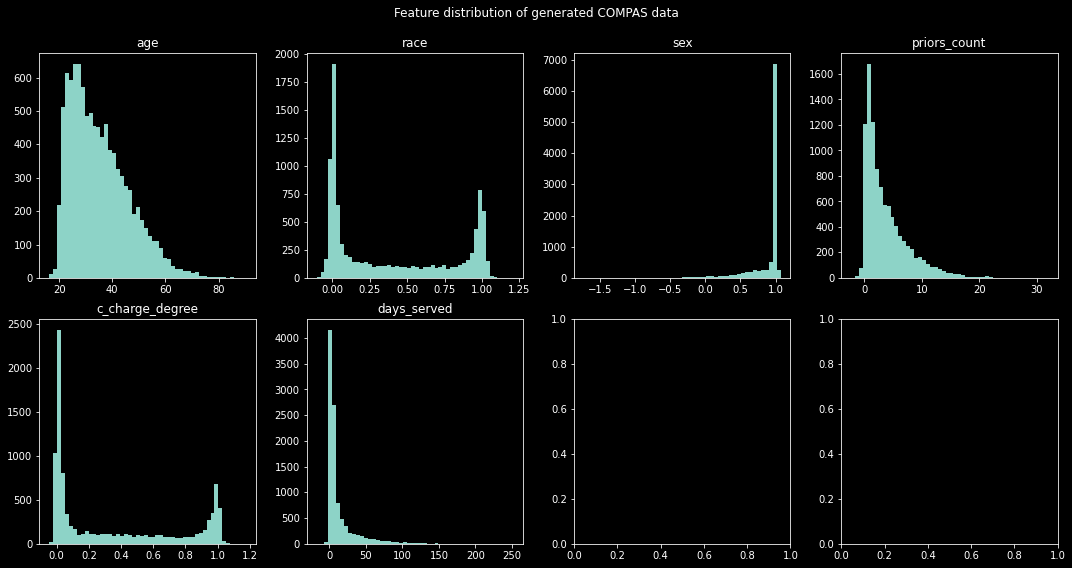

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(compas_data[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of original COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()


fig, ax = plt.subplots(2, 4, figsize=(15, 8))
axes = ax.ravel()

for feature_index, feature in enumerate(compas_df.columns):
  axis = axes[feature_index]
  axis.hist(y_samples[:,feature_index], bins=50)
  axis.set_title(feature)
  
plt.suptitle("Feature distribution of generated COMPAS data")
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.show()

#### Pickle the weights

In [ ]:
filename = f"{parameter_path}/COMPAS_generated/compas_vae_D_{D}_.weights"
pickle_vae_weights(compas_vae, filename)

### Save the architecture

In [ ]:
filename =f"{parameter_path}/COMPAS_generated/compas_vae_D_{D}_architecture.txt"
save_architecture(compas_vae.encoder, compas_vae.decoder, D, filename)